# Optimizing the AM NCO model: `flash_attn` and `float16`

Here we try to optimize the graph encoder AM. We use the Minsu's implementation in [Sym-NCO](https://github.com/alstn12088/Sym-NCO/blob/main/Sym-NCO-AM/nets/graph_encoder.py) of the graph encoder

In [1]:
import torch
import numpy as np
from torch import nn
import math

from flash_attn.flash_attention import FlashMHA

## Flash modules
Here we use [Flash Attention](https://github.com/HazyResearch/flash-attention) to greatly speedup the computations. This is exact attention, so no information is lost - it just uses IO devices in a smart way


In [2]:
class FlashMultiHeadAttention(FlashMHA):
    def __init__(
            self,
            n_heads,
            input_dim,
            embed_dim,
            val_dim=None,
            key_dim=None
    ):
        super(FlashMultiHeadAttention, self).__init__(
            embed_dim,
            n_heads,
            dtype=torch.float16,
        )


class FlashSkipConnection(nn.Module):

    def __init__(self, module, dtype=torch.float32):
        super(FlashSkipConnection, self).__init__()
        self.module = module
        self.dtype = dtype

    def forward(self, x):
        # original dtype 
        original_dtype = x.dtype
        module_dtype = self.dtype

        # cast x dtype to module dtype
        x = x.to(module_dtype)

        y = self.module(x)[0]
        y = x + y
        
        return y.to(original_dtype)

## Normal modules
Here are the normal modules

In [3]:
class SkipConnection(nn.Module):

    def __init__(self, module, **kwargs):
        super(SkipConnection, self).__init__()
        self.module = module

    def forward(self, input):
        return input + self.module(input)
    

class MultiHeadAttention(nn.Module):
    def __init__(
            self,
            n_heads,
            input_dim,
            embed_dim,
            val_dim=None,
            key_dim=None
    ):
        super(MultiHeadAttention, self).__init__()

        if val_dim is None:
            val_dim = embed_dim // n_heads
        if key_dim is None:
            key_dim = val_dim

        self.n_heads = n_heads
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.val_dim = val_dim
        self.key_dim = key_dim

        self.norm_factor = 1 / math.sqrt(key_dim)  # See Attention is all you need

        self.W_query = nn.Parameter(torch.Tensor(n_heads, input_dim, key_dim))
        self.W_key = nn.Parameter(torch.Tensor(n_heads, input_dim, key_dim))
        self.W_val = nn.Parameter(torch.Tensor(n_heads, input_dim, val_dim))

        self.W_out = nn.Parameter(torch.Tensor(n_heads, val_dim, embed_dim))

        self.init_parameters()

    def init_parameters(self):

        for param in self.parameters():
            stdv = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-stdv, stdv)

    def forward(self, q, h=None, mask=None):
        """

        :param q: queries (batch_size, n_query, input_dim)
        :param h: data (batch_size, graph_size, input_dim)
        :param mask: mask (batch_size, n_query, graph_size) or viewable as that (i.e. can be 2 dim if n_query == 1)
        Mask should contain 1 if attention is not possible (i.e. mask is negative adjacency)
        :return:
        """
        if h is None:
            h = q  # compute self-attention

        # h should be (batch_size, graph_size, input_dim)
        batch_size, graph_size, input_dim = h.size()
        n_query = q.size(1)
        assert q.size(0) == batch_size
        assert q.size(2) == input_dim
        assert input_dim == self.input_dim, "Wrong embedding dimension of input"

        hflat = h.contiguous().view(-1, input_dim)
        qflat = q.contiguous().view(-1, input_dim)

        # last dimension can be different for keys and values
        shp = (self.n_heads, batch_size, graph_size, -1)
        shp_q = (self.n_heads, batch_size, n_query, -1)

        # Calculate queries, (n_heads, n_query, graph_size, key/val_size)
        Q = torch.matmul(qflat, self.W_query).view(shp_q)
        # Calculate keys and values (n_heads, batch_size, graph_size, key/val_size)
        K = torch.matmul(hflat, self.W_key).view(shp)
        V = torch.matmul(hflat, self.W_val).view(shp)

        # Calculate compatibility (n_heads, batch_size, n_query, graph_size)
        compatibility = self.norm_factor * torch.matmul(Q, K.transpose(2, 3))

        # Optionally apply mask to prevent attention
        if mask is not None:
            mask = mask.view(1, batch_size, n_query, graph_size).expand_as(compatibility)
            compatibility[mask] = -np.inf

        attn = torch.softmax(compatibility, dim=-1)

        # If there are nodes with no neighbours then softmax returns nan so we fix them to 0
        if mask is not None:
            attnc = attn.clone()
            attnc[mask] = 0
            attn = attnc

        heads = torch.matmul(attn, V)

        out = torch.mm(
            heads.permute(1, 2, 0, 3).contiguous().view(-1, self.n_heads * self.val_dim),
            self.W_out.view(-1, self.embed_dim)
        ).view(batch_size, n_query, self.embed_dim)

        # Alternative:
        # headst = heads.transpose(0, 1)  # swap the dimensions for batch and heads to align it for the matmul
        # # proj_h = torch.einsum('bhni,hij->bhnj', headst, self.W_out)
        # projected_heads = torch.matmul(headst, self.W_out)
        # out = torch.sum(projected_heads, dim=1)  # sum across heads

        # Or:
        # out = torch.einsum('hbni,hij->bnj', heads, self.W_out)

        return out

## Common utilities

Same as normal code, with small addition of `flash_attn` and `float16` flags

In [4]:
class Normalization(nn.Module):

    def __init__(self, embed_dim, normalization='batch'):
        super(Normalization, self).__init__()

        normalizer_class = {
            'batch': nn.BatchNorm1d,
            'instance': nn.InstanceNorm1d
        }.get(normalization, None)

        self.normalizer = normalizer_class(embed_dim, affine=True)

        # Normalization by default initializes affine parameters with bias 0 and weight unif(0,1) which is too large!
        # self.init_parameters()

    def init_parameters(self):

        for name, param in self.named_parameters():
            stdv = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-stdv, stdv)

    def forward(self, input):
        if isinstance(self.normalizer, nn.BatchNorm1d):
            return self.normalizer(input.view(-1, input.size(-1))).view(*input.size())
        elif isinstance(self.normalizer, nn.InstanceNorm1d):
            return self.normalizer(input.permute(0, 2, 1)).permute(0, 2, 1)
        else:
            assert self.normalizer is None, "Unknown normalizer type"
            return input


class MultiHeadAttentionLayer(nn.Sequential):

    def __init__(
            self,
            n_heads,
            embed_dim,
            feed_forward_hidden=512,
            normalization='batch',
            use_flash_attn=False,
            dtype=torch.float32
    ):
        SkipConnectionModule = FlashSkipConnection if use_flash_attn else SkipConnection
        MultiHeadAttentionModule = FlashMultiHeadAttention if use_flash_attn else MultiHeadAttention
        super(MultiHeadAttentionLayer, self).__init__(
            SkipConnectionModule(
                MultiHeadAttentionModule(
                    n_heads,
                    input_dim=embed_dim,
                    embed_dim=embed_dim
                ),
                dtype=torch.float16 # force fp16 for flash attention. Does not influence the rest of the model
            ),
            Normalization(embed_dim, normalization),
            SkipConnection(
                nn.Sequential(
                    nn.Linear(embed_dim, feed_forward_hidden),
                    nn.ReLU(),
                    nn.Linear(feed_forward_hidden, embed_dim)
                ) if feed_forward_hidden > 0 else nn.Linear(embed_dim, embed_dim),
            dtype=dtype
            ),
            Normalization(embed_dim, normalization)
        )


class GraphAttentionEncoder(nn.Module):
    def __init__(
            self,
            n_heads,
            embed_dim,
            n_layers,
            node_dim=None,
            normalization='batch',
            feed_forward_hidden=512,
            use_flash_attn=False
    ):
        super(GraphAttentionEncoder, self).__init__()



        # To map input to embedding space
        self.init_embed = nn.Linear(node_dim, embed_dim) if node_dim is not None else None

        self.layers = nn.Sequential(*(
            MultiHeadAttentionLayer(n_heads, embed_dim, feed_forward_hidden, normalization, use_flash_attn)
            for _ in range(n_layers)
        ))

    def forward(self, x, mask=None):

        assert mask is None, "TODO mask not yet supported!"

        # Batch multiply to get initial embeddings of nodes
        h = self.init_embed(x.view(-1, x.size(-1))).view(*x.size()[:2], -1) if self.init_embed is not None else x

        h = self.layers(h)

        return (
            h,  # (batch_size, graph_size, embed_dim)
            h.mean(dim=1),  # average to get embedding of graph, (batch_size, embed_dim)
        )

## Benchmarking
We make the benchmark run on GPU. We use an RTX 3090

To store results, we use [timeit](https://stackoverflow.com/questions/41351041/how-to-store-the-result-from-timeit-cell-magic)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Initialize model
model = GraphAttentionEncoder(
    n_heads=8,
    embed_dim=128,
    n_layers=6,
    node_dim=None,
    normalization='batch',
    feed_forward_hidden=512,
    use_flash_attn=False
)
model = model.to(device)

In [7]:
# Intialize model flash
# Initialize model
model_flash = GraphAttentionEncoder(
    n_heads=8,
    embed_dim=128,
    n_layers=6,
    node_dim=None,
    normalization='batch',
    feed_forward_hidden=512,
    use_flash_attn=True
)
model_flash = model_flash.to(device)

In [8]:
# Initialize input
x = torch.randn(1024, 100, 128) # same as original implementation

# Move to GPU
x = x.to(device)

### Normal model

In [9]:
# Dummy run
%timeit -r 1 -n 1 model(x)
_

559 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


''

In [10]:
%timeit -o -r 10 -n 10 model(x)

47.2 ms ± 8.51 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 47.2 ms ± 8.51 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [11]:
result_model = _ 

### Flash Attention

In [12]:
# Dummy run
%timeit -r 1 -n 1 model_flash(x)
_

9.87 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 47.2 ms ± 8.51 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [13]:
%timeit -o -r 10 -n 10  model_flash(x)

24.4 ms ± 2.27 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 24.4 ms ± 2.27 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [14]:
result_model_flash = _ 

### Flash Attention + Float16

In [15]:
# Make x FP16
x = x.half()

# Make all parameters FP16
for param in model_flash.parameters():
    param.data = param.data.half()

In [16]:
# Dummy run
%timeit -r 1 -n 1 model_flash(x)
_

6.71 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 24.4 ms ± 2.27 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [17]:
%timeit -o -r 10 -n 10  model_flash(x)

9.91 ms ± 1.95 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 9.91 ms ± 1.95 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [18]:
result_model_flash_fp16 = _ 

## Plot results

Text(0, 0.5, 'Time (s)')

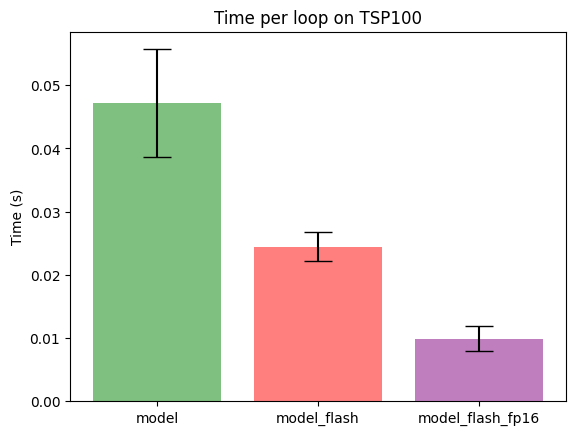

In [19]:
# Make bar plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
models = ['model', 'model_flash', 'model_flash_fp16']
times = [result_model.average, result_model_flash.average, result_model_flash_fp16.average]
times_std = [result_model.stdev, result_model_flash.stdev, result_model_flash_fp16.stdev]
colors = ['green', 'red', 'purple']

ax.bar(models, times, yerr=times_std, align='center', alpha=0.5, ecolor='black', capsize=10, color=colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Time per loop on TSP100')

ax.set_ylabel('Time (s)')

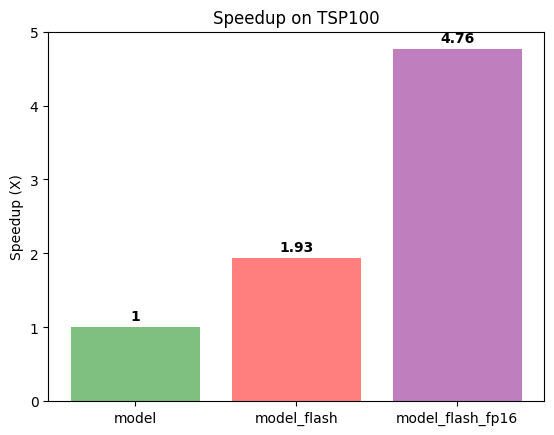

In [20]:
# Same plot, but with speedup compared to model
fig, ax = plt.subplots()
models = ['model', 'model_flash', 'model_flash_fp16']
speedup = [1, result_model.average / result_model_flash.average, result_model.average / result_model_flash_fp16.average]

ax.bar(models, speedup, align='center', alpha=0.5, ecolor='black', capsize=10, color=colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Speedup on TSP100')
ax.set_ylabel('Speedup (X)')

# Print value on top of bar
for i, v in enumerate(speedup):
    ax.text(i, v + 0.1, str(round(v, 2)), color='black', fontweight='bold', horizontalalignment='center')